# Classificador de dígitos completo

#### Estratégia "Um Contra Todos"
Classificação Binária para cada dígito: Para cada dígito 𝑖, cria-se um classificador binário que tenta distinguir o dígito 𝑖 dos demais.

Para o dígito 0: 𝑦 = +1 para 0, y=−1 para 1, 4 e 5. <br>
Para o dígito 1: 𝑦 = +1 para 1, y=−1 para 4 e 5 (0 é removido). <br>
Para o dígito 4: 𝑦 = +1 para 4, y=−1 para 5 (0 e 1 são removidos). <br>

### Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from modelos.Perceptron import PLA, classify
from modelos.RegressaoLinear import LinearRegression
from modelos.RegressaoLogistica import LogisticRegression

### Visualização de Dados

A função `plot_simetria_intensidade` carrega e visualiza os dados de simetria e intensidade para conjuntos de treino e teste.

- **Carregamento dos dados**: Os datasets reduzidos são carregados a partir de arquivos CSV.
- **Criação de Arrays**: Os arrays `X_treino`, `y_treino`, `X_teste` e `y_teste` são criados para armazenar as características (simetria e intensidade) e os rótulos das classes.
- **Visualização**: São gerados gráficos de dispersão para os conjuntos de treino e teste, com as cores representando as classes dos dados.
- **Retorno**: A função retorna os dataframes e arrays gerados para uso posterior.

In [2]:
#primeiros resultados arq de treino
df_train_redu = pd.read_csv('dataset_digits/train_redu.csv', delimiter=';')
print("Primeiras linhas do arquivo train_redu.csv:")
print(df_train_redu.head())

#primeiros resultados arq de teste
df_test_redu = pd.read_csv('dataset_digits/test_redu.csv', delimiter=';')
print("\nPrimeiras linhas do arquivo test_redu.csv:")
print(df_test_redu.head())

Primeiras linhas do arquivo train_redu.csv:
   label  intensidade    simetria
0      0   145.435294  148.572549
1      0   118.576471  137.113725
2      0   127.600000  134.047059
3      0   138.047059  151.003922
4      0   146.215686  122.501961

Primeiras linhas do arquivo test_redu.csv:
   label  intensidade    simetria
0      0   147.933333  130.470588
1      0   131.054902  122.721569
2      0   134.890196  151.725490
3      0   139.976471  133.921569
4      0   129.580392  130.274510


In [3]:
# Verificar a distribuição das labels
print("\nDistribution of Labels in Train Data:")
print(df_train_redu['label'].value_counts())

print("\nDistribution of Labels in Test Data:")
print(df_test_redu['label'].value_counts())


Distribution of Labels in Train Data:
1    608
4    577
5    576
0    425
Name: label, dtype: int64

Distribution of Labels in Test Data:
4    314
1    292
5    291
0    218
Name: label, dtype: int64


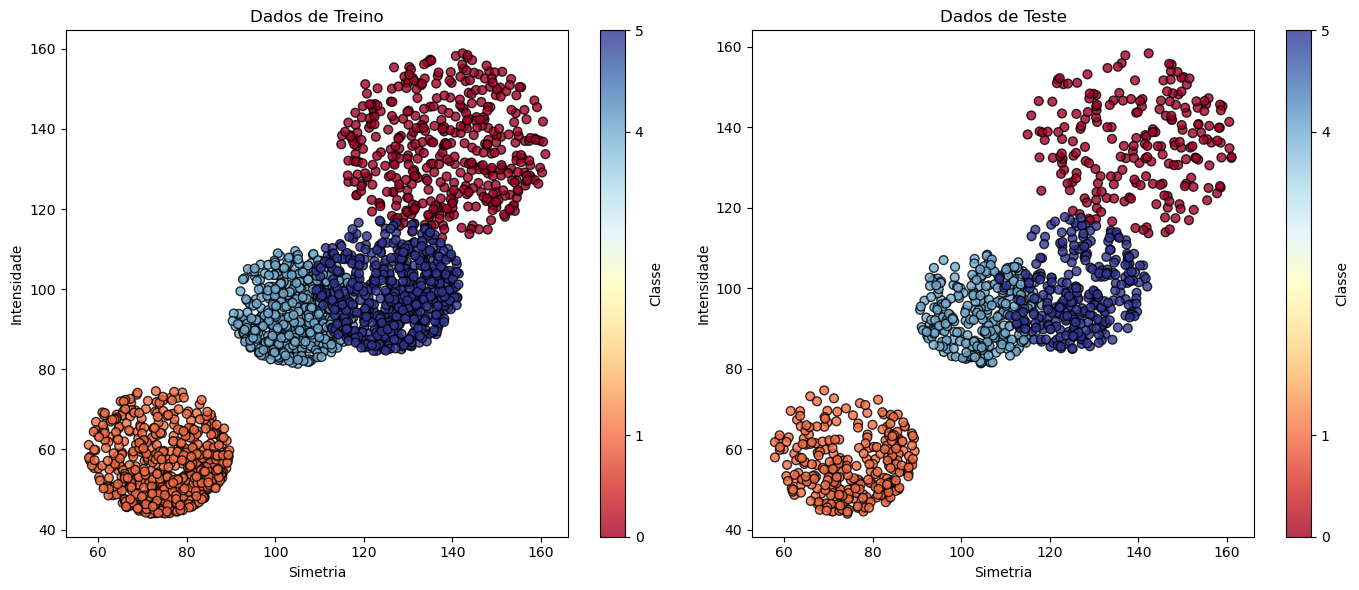

In [4]:
def plot_simetria_intensidade(caminho_treino, caminho_teste):
    # Carrega os datasets reduzidos
    df_treino = pd.read_csv(caminho_treino, delimiter=';')
    df_teste = pd.read_csv(caminho_teste, delimiter=';')
    
    # Cria arrays para simetria e intensidade
    X_treino = df_treino[['simetria', 'intensidade']].values
    y_treino = df_treino['label']
    
    X_teste = df_teste[['simetria', 'intensidade']].values
    y_teste = df_teste['label']

    # Plotar gráficos
    plt.figure(figsize=(14, 6))

    # Gráfico de treino
    plt.subplot(1, 2, 1)
    scatter_treino = plt.scatter(X_treino[:, 0], X_treino[:, 1], c=y_treino, cmap=plt.cm.RdYlBu, edgecolor='k', s=40, alpha=0.8)
    plt.title('Dados de Treino')
    plt.xlabel('Simetria')
    plt.ylabel('Intensidade')
    plt.colorbar(scatter_treino, ticks=np.unique(y_treino), label='Classe')

    # Gráfico de teste
    plt.subplot(1, 2, 2)
    scatter_teste = plt.scatter(X_teste[:, 0], X_teste[:, 1], c=y_teste, cmap=plt.cm.RdYlBu, edgecolor='k', s=40, alpha=0.8)
    plt.title('Dados de Teste')
    plt.xlabel('Simetria')
    plt.ylabel('Intensidade')
    plt.colorbar(scatter_teste, ticks=np.unique(y_teste), label='Classe')

    plt.tight_layout()
    plt.show()
    
    return df_treino, df_teste, X_treino, X_teste, y_treino, y_teste
    
    
# Exemplo de como usar a função
df_treino, df_teste, X_treino, X_teste, y_treino, y_teste = plot_simetria_intensidade('dataset_digits/train_redu.csv', 'dataset_digits/test_redu.csv')

### Criação de Datasets Binários

A função `criar_dataset_binario` transforma um dataframe em um dataset binário para a classificação de dígitos. Ela permite criar datasets para um dígito específico, convertendo-o para a classe `1` e todos os outros dígitos para a classe `-1`. Também é possível excluir rótulos indesejados.

- **Parâmetros**:
  - `df`: DataFrame com os dados originais.
  - `digito`: Dígito que será convertido para a classe `1`.
  - `excluir_labels`: Lista de rótulos que devem ser excluídos do dataset.

- **Processo**:
  - O DataFrame é copiado e rótulos indesejados são excluídos.
  - O dígito selecionado é atribuído à classe `1`, e todos os outros são atribuídos à classe `-1`.

- **Criação de Datasets Binários**:
  - `df_0_x_todos_treino`: Dataset binário para o dígito `0`.
  - `df_1_x_todos_treino`: Dataset binário para o dígito `1`, excluindo o dígito `0`.
  - `df_4_x_todos_treino`: Dataset binário para o dígito `4`, excluindo os dígitos `0` e `1`.

In [5]:
def criar_dataset_binario(df, digito, excluir_labels=None):
    
    if excluir_labels is None:
        excluir_labels = []

    df_binario = df.copy()
    df_binario = df_binario[~df_binario['label'].isin(excluir_labels)]  # Excluir labels
    df_binario['label'] = df_binario['label'].apply(lambda x: 1 if x == digito else -1)
    return df_binario

In [6]:
# Criar datasets binários para treino
df_0_x_todos_treino = criar_dataset_binario(df_treino, 0)

# Criar dataset binário para o dígito 1, excluindo label 0
df_1_x_todos_treino = criar_dataset_binario(df_treino, 1, excluir_labels=[0])

# Criar dataset binário para o dígito 4, excluindo labels 0 e 1
df_4_x_todos_treino = criar_dataset_binario(df_treino, 4, excluir_labels=[0,1])


# Exibindo os datasets binários criados
print(f"\nDataset 0 x Todos - Treino:\n {df_0_x_todos_treino[df_0_x_todos_treino['label'] == 1]}")
print(f"\nDataset 1 x Todos - Treino:\n {df_1_x_todos_treino[df_1_x_todos_treino['label'] == 1]}")
print(f"\nDataset 4 x Todos - Treino:\n {df_4_x_todos_treino[df_4_x_todos_treino['label'] == 1]}")


Dataset 0 x Todos - Treino:
      label  intensidade    simetria
0        1   145.435294  148.572549
1        1   118.576471  137.113725
2        1   127.600000  134.047059
3        1   138.047059  151.003922
4        1   146.215686  122.501961
..     ...          ...         ...
420      1   135.000000  119.803922
421      1   150.913725  152.956863
422      1   139.949020  137.772549
423      1   131.176471  136.980392
424      1   114.941176  138.156863

[425 rows x 3 columns]

Dataset 1 x Todos - Treino:
       label  intensidade   simetria
425       1    44.701961  69.270588
426       1    59.850980  83.443137
427       1    48.552941  79.043137
428       1    69.435294  72.878431
429       1    51.541176  84.611765
...     ...          ...        ...
1028      1    58.639216  89.419608
1029      1    57.168627  62.164706
1030      1    70.105882  66.125490
1031      1    67.411765  63.192157
1032      1    51.674510  76.949020

[608 rows x 3 columns]

Dataset 4 x Todos - Treino:

In [7]:

X_treino_f0 = df_0_x_todos_treino[['intensidade', 'simetria']].values
y_treino_f0 = df_0_x_todos_treino['label'].values

X_treino_f1 = df_1_x_todos_treino[['intensidade', 'simetria']].values
y_treino_f1 = df_1_x_todos_treino['label'].values

X_treino_f4 = df_4_x_todos_treino[['intensidade', 'simetria']].values
y_treino_f4 = df_4_x_todos_treino['label'].values

## Análise da distribuição dos dados
   - O estudo da distribuição dos dados se faz necessário para que possamos entender a organização do nosso conjunto e aplicar métodos que podem nos ajudar no desempenho dos algoritmos 

### Distribuição Normal

- **Se os dados são normalmente distribuídos (`p_value > 0.05`), a padronização é recomendada.**
  - **Por quê?** A padronização (ou z-score normalization) é apropriada para dados que seguem uma distribuição normal, pois transforma os dados para ter uma média de 0 e um desvio padrão de 1.

### Não Distribuição Normal ou Desvio Padrão Pequeno

- **Se os dados não são normalmente distribuídos (`p_value <= 0.05`) ou têm um desvio padrão pequeno (`std_dev < 1.0`), a normalização é recomendada.**
  - **Por quê?** A normalização (ou min-max scaling) é adequada para dados que não seguem uma distribuição normal ou têm uma variação pequena, pois transforma os dados para um intervalo fixo (por exemplo, 0 a 1).


In [8]:
from scipy.stats import shapiro

def verificar_distribuicao(X, dataset_nome):
    colunas = ['intensidade', 'simetria']
    for i, coluna in enumerate(colunas):
        stat, p_value = shapiro(X[:, i])
        std_dev = np.std(X[:, i])

        print(f"\nDataset {dataset_nome} - Coluna: {coluna}")
        print(f"Estatística Shapiro-Wilk: {stat}, p-value: {p_value}")
        print(f"Desvio padrão: {std_dev}")
        
        if p_value > 0.05:
            print("Distribuição normal")
            print("---Aconselhável padronizar os dados---")
        else:
            print("Não é uma distribuição normal")
            print("---Aconselhável normalizar os dados---")

        if std_dev < 1.0:
            print("Desvio padrão pequeno")
            print("---Aconselhável normalizar os dados---")

In [9]:
verificar_distribuicao(X_treino_f0, "f_0")
verificar_distribuicao(X_treino_f1, "f_1")
verificar_distribuicao(X_treino_f4, "f_4")


Dataset f_0 - Coluna: intensidade
Estatística Shapiro-Wilk: 0.9586645364761353, p-value: 1.8457515024871563e-24
Desvio padrão: 28.34597315503491
Não é uma distribuição normal
---Aconselhável normalizar os dados---

Dataset f_0 - Coluna: simetria
Estatística Shapiro-Wilk: 0.9662236571311951, p-value: 3.1643293501204567e-22
Desvio padrão: 25.27451127175848
Não é uma distribuição normal
---Aconselhável normalizar os dados---

Dataset f_1 - Coluna: intensidade
Estatística Shapiro-Wilk: 0.8891103267669678, p-value: 8.610112247399316e-34
Desvio padrão: 20.92801449244284
Não é uma distribuição normal
---Aconselhável normalizar os dados---

Dataset f_1 - Coluna: simetria
Estatística Shapiro-Wilk: 0.9560656547546387, p-value: 1.2918365989060116e-22
Desvio padrão: 22.46090414675433
Não é uma distribuição normal
---Aconselhável normalizar os dados---

Dataset f_4 - Coluna: intensidade
Estatística Shapiro-Wilk: 0.9816068410873413, p-value: 6.469515201334985e-11
Desvio padrão: 7.817115803795567
Nã

### Função para normalizar dados

Antes de ajustar o modelo de regressão logística, os dados são normalizados. A normalização é feita subtraindo a média e dividindo pelo desvio padrão de cada característica. Isso é feito para garantir que todas as características tenham a mesma escala e contribuir igualmente para o modelo.

A fórmula para a normalização é:

$$
X_{\text{norm}} = \frac{X - \text{mean}(X)}{\text{std}(X)}
$$

onde $\text{mean}(X)$ é a média das características e $\text{std}(X)$ é o desvio padrão.

In [10]:
import numpy.linalg as LA

def normalizar_manual(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

### Função para Plotar a Fronteira de Decisão

A função `plot_decision_boundaries` é uma função genérica para plotar as fronteiras de decisão para todos os três tipos de modelos. A ideia é fazer com que a função trate de forma flexível as diferenças entre os modelos (Perceptron, Regressão Linear e Regressão Logística) e plotar as fronteiras de decisão adequadamente.

- **Plotagem dos Dados**: Os dados são plotados em um gráfico de dispersão, coloridos de acordo com suas classes.
- **Desenho da Fronteira de Decisão**: Calcula e plota a linha de decisão baseada nos pesos aprendidos.
- **Configuração do Gráfico**: Ajusta os eixos, títulos e legenda, e adiciona uma barra de cores para mostrar as classes preditas.

In [11]:
def plot_decision_boundaries(X, y_true, y_pred, modelos, labels, model_type):
    plt.figure(figsize=(12, 8))
    
    class_colors = {0: 'blue', 1: 'green', 4: 'red', 5: 'orange'}
    
    scatter = plt.scatter(X[:, 0], X[:, 1], c=[class_colors[yi] for yi in y_pred], edgecolor='k', s=40, alpha=0.8)

    x_values = np.linspace(X[:, 0].min() - 5, X[:, 0].max() + 5, 100)
    
    for modelo, label in zip(modelos, labels):
        w = modelo.getW() if model_type in ['linear_regression', 'logistic_regression'] else modelo
        bias = w[0]
        coef = w[1:]

        # Determinar a cor da linha de decisão
        class_label = int(label.split()[0][1])  
        line_color = class_colors[class_label]
        
        if len(coef) > 1:
            y_values = - (coef[0] * x_values + bias) / coef[1]
            plt.plot(x_values, y_values, label=f'{label} Decision Boundary', linestyle='--', color=line_color)
        else:
            print(f'Não é possível plotar a fronteira de decisão para {label}. Coeficiente insuficiente.')

        # Imprimindo a função hipótese
        if model_type in ['linear_regression', 'logistic_regression']:
            print(f"Função hipótese para {label}: h(x) = {bias:.3f} + {coef[0]:.3f}*intensidade + {coef[1]:.3f}*simetria")

    if model_type == 'linear_regression':
        plt.xlim(40, 160)
        plt.ylim(50,170)
    else:
        plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
        plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    
    plt.title(f'Resultados da Classificação por {model_type.capitalize()} com Fronteiras de Decisão')
    plt.xlabel('Intensidade')
    plt.ylabel('Simetria')
    

    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, linestyle='') 
               for color in class_colors.values()]
    plt.legend(handles=handles, labels=list(class_colors.keys()), title='Classe Predita')
    plt.show()

### Função para Classificar Dígitos

A função `classificar_digito` classifica um dígito usando diferentes tipos de modelos (Perceptron, Regressão Linear e Regressão Logística). 

- **Entrada**: Ajusta o formato do exemplo `x` para ser um array 2D.
- **Previsão**: Dependendo do tipo de modelo:
  - **Perceptron**: Usa a função `classify` para obter previsões.
  - **Regressão Linear e Logística**: Usa o método `predict` dos modelos.
- **Classificação**: Retorna o dígito com base nas previsões para `f0`, `f1` e `f4`:
    - **Modelo `f_0`**: Classifica o dígito `0` contra os dígitos `1`, `4`, e `5`.
    - **Modelo `f_1`**: Classifica o dígito `1` contra os dígitos `4`, e `5`.
    - **Modelo `f_4`**: Classifica o dígito `4` contra os dígitos `5`.
    - 5 se nenhum dos anteriores for positivo
 
- **Erro**: Levanta um erro para tipos de modelos desconhecidos.

In [12]:
def classificar_digito(x, modelos, model_type):

    x = np.array(x).reshape(1, -1)
    
    if model_type == 'linear_regression':
        pred_f0 = modelos[0].predict(x)
        pred_f1 = modelos[1].predict(x)
        pred_f4 = modelos[2].predict(x)
    
    elif model_type == 'logistic_regression':
        pred_f0 = modelos[0].predict(x)
        pred_f1 = modelos[1].predict(x)
        pred_f4 = modelos[2].predict(x)
    
    else:
        raise ValueError("Tipo de modelo desconhecido. Use 'linear_regression' ou 'logistic_regression'.")
    
    # Classificar o dígito com base nas previsões
    if pred_f0 > 0:
        return 0
    elif pred_f1 > 0:
        return 1
    elif pred_f4 > 0:
        return 4
    else:
        return 5

## ➞ Perceptron

### 1. Normalização dos Dados

Normalizando os dados de treinamento e teste usando a função `normalizar_manual`. Isso é feito para garantir que as características tenham a mesma escala, o que ajuda na convergência do modelo.

In [13]:
X_treino_f0_norm = normalizar_manual(X_treino_f0)
X_treino_f1_norm = normalizar_manual(X_treino_f1)
X_treino_f4_norm = normalizar_manual(X_treino_f4)

### 2. Treinamento dos Modelos Perceptron

Três modelos de Perceptron são treinados para distinguir entre o dígito de interesse e outros dígitos com a função `PLA` (Perceptron Learning Algorithm) que é usada para ajustar os pesos dos modelos.

In [14]:
it_f0, w_f0 = PLA(X_treino_f0_norm, y_treino_f0)
it_f1, w_f1 = PLA(X_treino_f1_norm, y_treino_f1, max_iter=1000)
it_f4, w_f4 = PLA(X_treino_f4_norm, y_treino_f4, max_iter=2000)

Limite máximo de iterações atingido.
Solução encontrada após 3 iterações.
Limite máximo de iterações atingido.


### 3. Previsões e Avaliação

Fazemos as previsões no conjunto de teste e avalia o desempenho do modelo usando a matriz de confusão e o relatório de classificação.

In [15]:
X_teste = normalizar_manual(df_teste[['intensidade', 'simetria']].values)


def classificar_digito_perceptron(x):
    x = x.reshape(1,-1)
    pred_f0 = classify(x, w_f0)
    pred_f1 = classify(x, w_f1)
    pred_f4 = classify(x, w_f4)
    
    if pred_f0 > 0:
        return 0
    elif pred_f1 > 0:
        return 1
    elif pred_f4 > 0:
        return 4
    else:
        return 5


y_pred_perceptron = np.array([classificar_digito_perceptron(x) for x in X_teste])


conf_matrix_perceptron = confusion_matrix(y_teste, y_pred_perceptron)
class_report_perceptron = classification_report(y_teste, y_pred_perceptron, target_names=['0', '1', '4', '5'], zero_division=1)

print("Matriz de Confusão (Perceptron):")
print(conf_matrix_perceptron)
print("\nRelatório de Classificação (Perceptron):")
print(class_report_perceptron)

Matriz de Confusão (Perceptron):
[[217   0   0   1]
 [  0 292   0   0]
 [  0   0 222  92]
 [  1   0   3 287]]

Relatório de Classificação (Perceptron):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       292
           4       0.99      0.71      0.82       314
           5       0.76      0.99      0.86       291

    accuracy                           0.91      1115
   macro avg       0.93      0.92      0.92      1115
weighted avg       0.93      0.91      0.91      1115



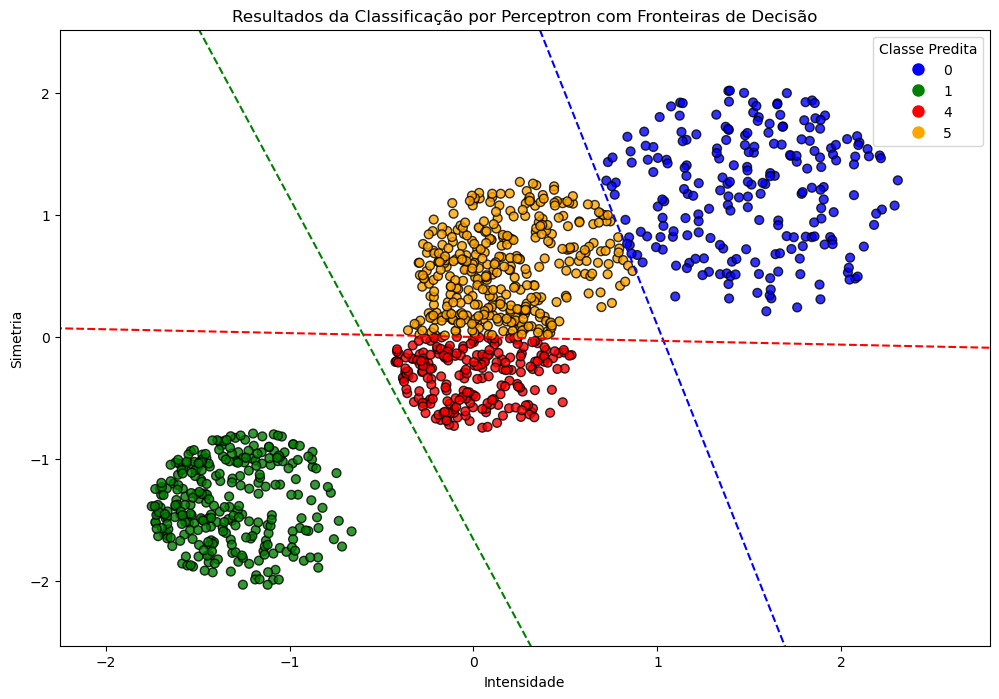

In [16]:
labels = ['f0 (0 contra todos)', 'f1 (1 contra todos)', 'f4 (4 contra todos)']
modelos = [w_f0, w_f1, w_f4]
plot_decision_boundaries(X_teste, y_teste, y_pred_perceptron, modelos, labels, model_type='perceptron')

## ➞ Regressão Linear

### 1. Treinamento dos Modelos de Regressão Linear

O código treina três modelos de regressão linear para distinguir entre dígitos específicos. Cada modelo é ajustado para classificar um dígito contra outros.

In [17]:
# dígito 0 contra 1, 4, 5
X_treino_f0 = df_0_x_todos_treino[['intensidade', 'simetria']].values
y_treino_f0 = df_0_x_todos_treino['label'].values

# dígito 1 contra  4, 5
X_treino_f1 = df_1_x_todos_treino[['intensidade', 'simetria']].values
y_treino_f1 = df_1_x_todos_treino['label'].values

# dígito 4 contra 5
X_treino_f4 = df_4_x_todos_treino[['intensidade', 'simetria']].values
y_treino_f4 = df_4_x_todos_treino['label'].values


modelo_f0 = LinearRegression()
modelo_f0.fit(X_treino_f0, y_treino_f0)

modelo_f1 = LinearRegression()
modelo_f1.fit(X_treino_f1, y_treino_f1)

modelo_f4 = LinearRegression()
modelo_f4.fit(X_treino_f4, y_treino_f4)

### 2. Classificação e Avaliação

As previsões são feitas para o conjunto de teste e o desempenho é avaliado com a matriz de confusão e o relatório de classificação.

In [18]:
X_teste = df_teste[['intensidade', 'simetria']].values
y_teste = df_teste['label'].values


y_pred_rl = np.array([classificar_digito(x, [modelo_f0, modelo_f1, modelo_f4], 'linear_regression') for x in X_teste])


conf_matrix_lr = confusion_matrix(y_teste, y_pred_rl)
class_report_lr = classification_report(y_teste, y_pred_rl, target_names=['0', '1', '4', '5'])

print(f"\nMatriz de Confusão (Teste):\n {conf_matrix_lr}")
print(f"\nRelatório de Classificação (Teste):\n{class_report_lr}")


Matriz de Confusão (Teste):
 [[174   0   0  44]
 [  0 292   0   0]
 [  0   0 306   8]
 [  0   0  24 267]]

Relatório de Classificação (Teste):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       218
           1       1.00      1.00      1.00       292
           4       0.93      0.97      0.95       314
           5       0.84      0.92      0.88       291

    accuracy                           0.93      1115
   macro avg       0.94      0.92      0.93      1115
weighted avg       0.94      0.93      0.93      1115



Função hipótese para f0 (0 contra todos): h(x) = -2.237 + 0.025*intensidade + -0.007*simetria
Função hipótese para f1 (1 contra todos): h(x) = 3.484 + -0.032*intensidade + -0.011*simetria
Função hipótese para f4 (4 contra todos): h(x) = 7.743 + -0.005*intensidade + -0.062*simetria


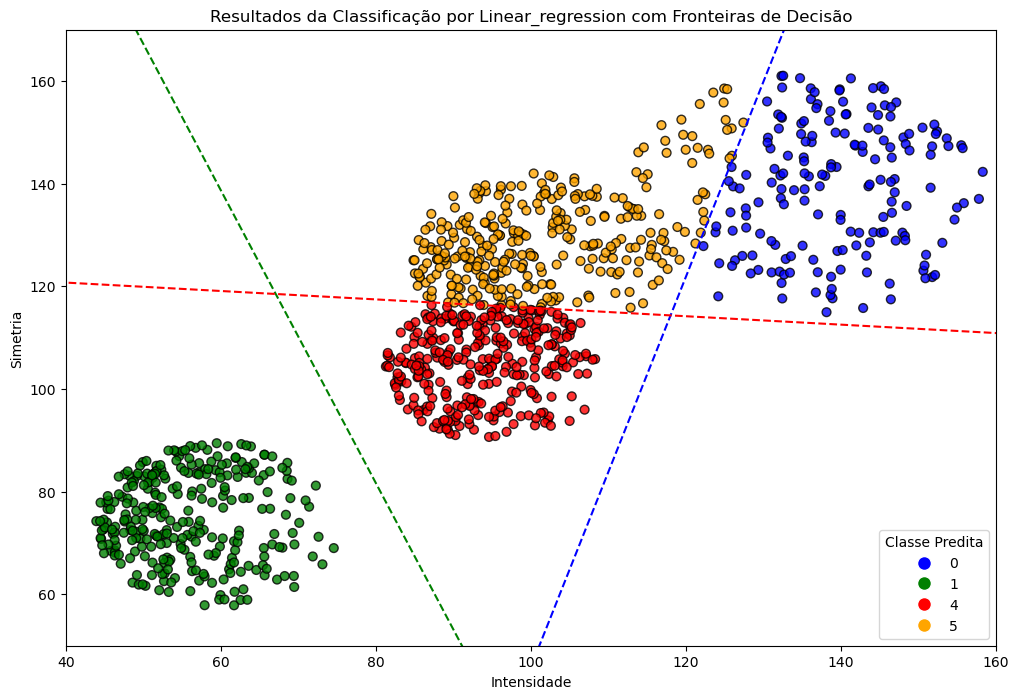

In [19]:
labels = ['f0 (0 contra todos)', 'f1 (1 contra todos)', 'f4 (4 contra todos)']
modelos = [modelo_f0, modelo_f1, modelo_f4]
plot_decision_boundaries(X_teste, y_teste, y_pred_rl, modelos, labels, model_type='linear_regression')

## ➞ Regressão Logística

### 1. Normalização dos Dados

Os dados de treino são normalizados para garantir que todas as características estejam na mesma escala. Os dados de teste também são normalizados antes da predição.

- **Função de Normalização**: `normalizar_manual` calcula a normalização dos dados.

In [20]:
# Normalizar os dados de treino
X_treino_f0_log = normalizar_manual(df_0_x_todos_treino[['intensidade', 'simetria']].values)
X_treino_f1_log = normalizar_manual(df_1_x_todos_treino[['intensidade', 'simetria']].values)
X_treino_f4_log = df_4_x_todos_treino[['intensidade', 'simetria']].values # Em df_4_x_todos os dados estão mais equilibrados por isso nao normalizei

y_treino_f0_log = df_0_x_todos_treino['label'].values
y_treino_f1_log = df_1_x_todos_treino['label'].values
y_treino_f4_log = df_4_x_todos_treino['label'].values


#eta é a taxa de aprendizado, que pode ser mdoficiada de acordo com a necessidade
modelo_f0_log = LogisticRegression(eta=0.01, tmax=1000) 
modelo_f1_log = LogisticRegression(eta=0.001, tmax=1000) 
modelo_f4_log = LogisticRegression(eta=0.001, tmax=1000)

modelo_f0_log.fit(X_treino_f0_log, y_treino_f0_log)
modelo_f1_log.fit(X_treino_f1_log, y_treino_f1_log)
modelo_f4_log.fit(X_treino_f4_log, y_treino_f4_log)

C:\Users\gonti\Handwritten-Digit-Recognition\Trabalho segmentado\modelos\RegressaoLogistica.py:33: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-z))


### 2. Predição e Avaliação

- **Predição**: Utiliza os modelos treinados para prever os rótulos dos dados de teste.
- **Avaliação**: A performance dos modelos é avaliada utilizando a matriz de confusão e o relatório de classificação.

In [21]:
X_teste = normalizar_manual(df_teste[['intensidade', 'simetria']].values)


X_teste_bias = np.c_[np.ones((X_teste.shape[0], 1)), X_teste]


modelos_rlog = [modelo_f0_log, modelo_f1_log, modelo_f4_log]


y_pred = np.array([classificar_digito(x, modelos_rlog, 'logistic_regression') for x in X_teste_bias])


Matriz de Confusão:
 [[155   0   0  63]
 [  0 292   0   0]
 [  0   0 221  93]
 [  0   0   0 291]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83       218
           1       1.00      1.00      1.00       292
           4       1.00      0.70      0.83       314
           5       0.65      1.00      0.79       291

    accuracy                           0.86      1115
   macro avg       0.91      0.85      0.86      1115
weighted avg       0.91      0.86      0.86      1115

Função hipótese para f0 (0 contra todos): h(x) = -7.931 + 3.907*intensidade + 2.902*simetria
Função hipótese para f1 (1 contra todos): h(x) = -0.730 + -0.731*intensidade + -0.667*simetria
Função hipótese para f4 (4 contra todos): h(x) = 0.000 + -2.311*intensidade + -10.633*simetria


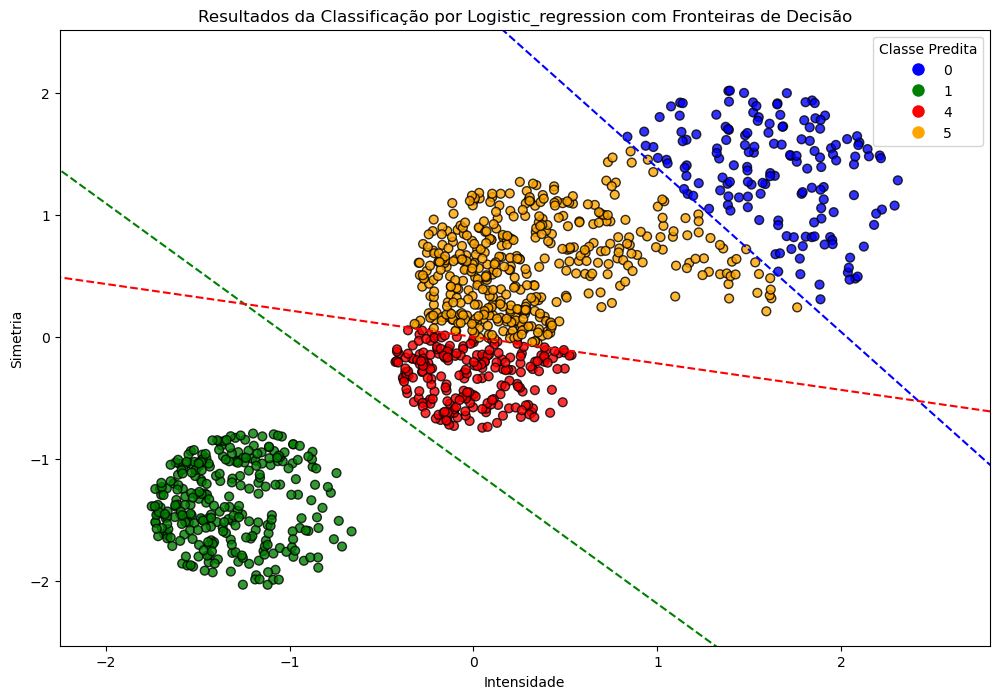

In [22]:
# Avaliar o desempenho
conf_matrix = confusion_matrix(y_teste, y_pred)
class_report = classification_report(y_teste, y_pred, target_names=['0', '1', '4', '5'])

print(f"\nMatriz de Confusão:\n {conf_matrix}")
print(f"\nRelatório de Classificação:\n {class_report}")

labels = ['f0 (0 contra todos)', 'f1 (1 contra todos)', 'f4 (4 contra todos)']
plot_decision_boundaries(X_teste, y_teste, y_pred, modelos_rlog, labels, model_type='logistic_regression')